In [1]:
!nvidia-smi

Sat Aug 10 13:01:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Setup

In [1]:
# install tensorflow 2.15 since voxelmorph is not compatible with current build
import tensorflow as tf
if not tf.__version__.startswith('2.15'):
  !pip uninstall -y tensorflow
  !pip install tensorflow==2.15
# install voxelmorph
!pip install voxelmorph

In [3]:
import voxelmorph as vxm
import neurite as ne

import os
import urllib.request
import zipfile
import json
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib import colors, patches
import numpy as np

# Download dataset

In [4]:
# download dataset
filename = 'AbdomenCTCT.zip'
if not os.path.exists(filename):
    url = 'https://cloud.imi.uni-luebeck.de/s/32WaSRaTnFk2JeT/download/AbdomenCTCT.zip'
    urllib.request.urlretrieve(url, filename)

    # extract files
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('./')

In [5]:
def load_data(jsonData, dataFolderPath, training_or_test,filterString='0001'):
    images = []
    for sample in jsonData[training_or_test]:
        image = nib.load(dataFolderPath + sample['image'].removeprefix('.')).get_fdata()
        images.append(image.astype(np.uint8))

    return np.array(images)

In [6]:
# load data
with open('./AbdomenCTCT/AbdomenCTCT_dataset.json', 'r') as file:
  data_json = json.load(file)
dataFolder = './AbdomenCTCT'
training_images_raw = load_data(data_json, dataFolder, 'training')

In [7]:
training_images_raw.shape

(30, 192, 160, 256)

# Preprocess data

In [8]:
# normalize images
training_images_normalized = training_images_raw / 255.

# rotate tensor
training_images_rotated = np.array([np.rot90(image, k=1, axes=(0, 2)) for image in training_images_normalized])

# swap and flip axes
training_images = np.swapaxes(training_images_rotated, 1, 2)[:, ::-1, :, :]

del training_images_raw
del training_images_normalized
del training_images_rotated

In [9]:
training_images.shape

(30, 160, 256, 192)

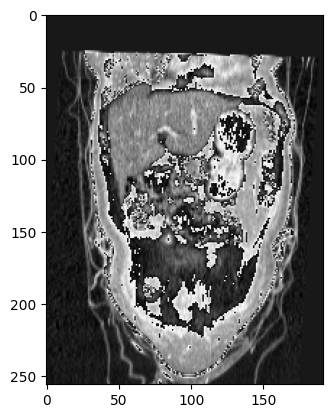

In [10]:
# preview data
img = 0
depth = 40

plt.imshow(training_images[img,depth],cmap='gray')

# Define Model

In [17]:
# Define the input shapes
inshape = training_images.shape[1:]
nb_features = (
    (16, 32, 32), # encoder-channels
    (32, 32, 16, 16) # decoder-channels
    )

# build model using VxmDense
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 160, 256, 192, 1), (None, 160, 256, 192, 1)
output shape: (None, 160, 256, 192, 1), (None, 160, 256, 192, 3)


In [18]:
# define loss functions
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# balance the two losses with hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

tf.Tensor(449.99994, shape=(), dtype=float32)


In [19]:
# compile model
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

# Train model

In [20]:
# define a data generator
def training_data_generator(data, batch_size):
    vol_shape = data.shape[1:]
    ndims = len(vol_shape)

    # prepare a zero array the size of the deformation
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    while True:
        idx1 = np.random.randint(0, data.shape[0], size=batch_size)
        idx2 = np.random.randint(0, data.shape[0], size=batch_size)

        fixed_image = data[idx1, ..., np.newaxis]
        moving_image = data[idx2, ..., np.newaxis]

        inputs = [moving_image, fixed_image]
        outputs = [fixed_image, zero_phi]

        yield (inputs, outputs)

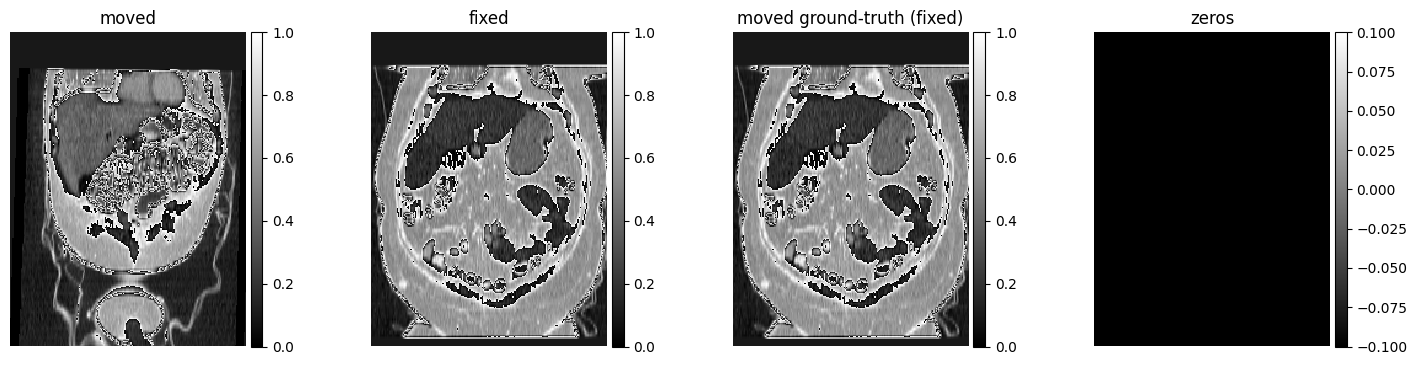

In [21]:
batch_size = 2

# define training generator
train_generator = training_data_generator(training_images, batch_size=batch_size)
in_sample, out_sample = next(train_generator)

# view generated data
images = [img[0, depth, :, :] for img in in_sample + out_sample]
titles = ['moved', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [22]:
# train model
nb_epochs = 100
steps_per_epoch = 20
validation_steps = 2
hist = vxm_model.fit(
    train_generator,
    epochs=nb_epochs,
    steps_per_epoch=steps_per_epoch,
    verbose=2
)

Epoch 1/30
20/20 - 93s - loss: -1.3916e-01 - vxm_dense_transformer_loss: -1.4372e-01 - vxm_dense_flow_loss: 0.0911 - 93s/epoch - 5s/step
Epoch 2/30
20/20 - 30s - loss: -1.7092e-01 - vxm_dense_transformer_loss: -1.7099e-01 - vxm_dense_flow_loss: 0.0013 - 30s/epoch - 1s/step
Epoch 3/30
20/20 - 29s - loss: -1.6426e-01 - vxm_dense_transformer_loss: -1.6430e-01 - vxm_dense_flow_loss: 8.8280e-04 - 29s/epoch - 1s/step
Epoch 4/30
20/20 - 30s - loss: -1.5160e-01 - vxm_dense_transformer_loss: -1.5165e-01 - vxm_dense_flow_loss: 0.0011 - 30s/epoch - 1s/step
Epoch 5/30
20/20 - 30s - loss: -1.4225e-01 - vxm_dense_transformer_loss: -1.4233e-01 - vxm_dense_flow_loss: 0.0015 - 30s/epoch - 1s/step
Epoch 6/30
20/20 - 30s - loss: -1.4030e-01 - vxm_dense_transformer_loss: -1.4033e-01 - vxm_dense_flow_loss: 4.5304e-04 - 30s/epoch - 1s/step
Epoch 7/30
20/20 - 30s - loss: -2.5845e-01 - vxm_dense_transformer_loss: -2.5846e-01 - vxm_dense_flow_loss: 2.7727e-04 - 30s/epoch - 1s/step
Epoch 8/30
20/20 - 30s - loss

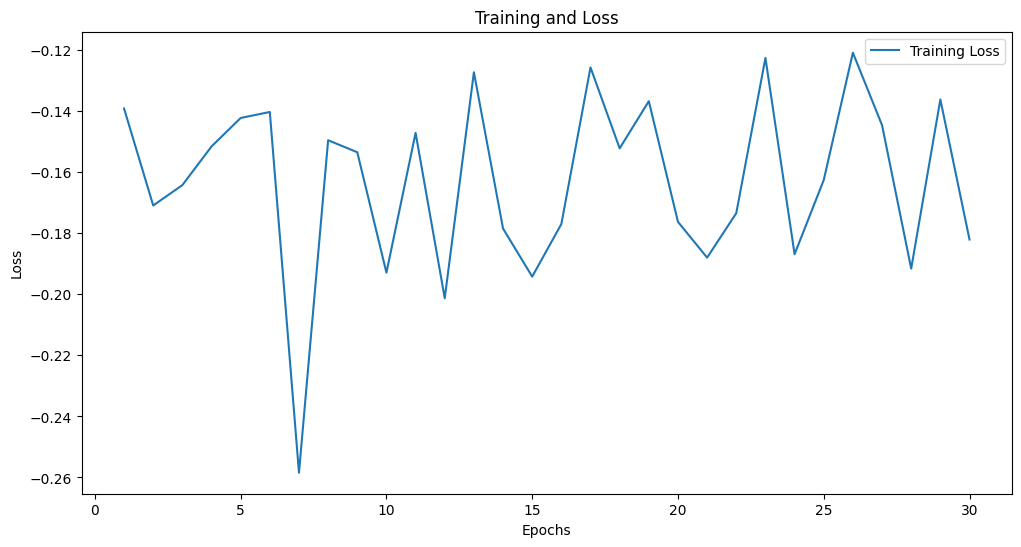

In [23]:
# extract train- and validation-loss
train_loss = hist.history['loss']

# plot history
plt.figure(figsize=(12, 6))
plt.plot(range(1, nb_epochs + 1), train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Loss')
plt.show()

# Save model

In [24]:
vxm_model.save_weights('AbdomenCTCT_model.h5')